<a href="https://colab.research.google.com/github/ashesh-0/PdfFromImages/blob/master/CRF_based_BookSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   Code inspiration taken from https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

*   Data created using https://labelbox.com



# Fetching Images and their masks

In [2]:
!pip install pydensecrf

     |████████████████████████████████| 1.0MB 6.4MB/s 
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc3-cp36-cp36m-linux_x86_64.whl size=2153790 sha256=9712b7a75656b31786dd0bf0641dcba6f0afecaca73afa19cd3c2c31552ac361
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


In [3]:
!pip install -q albumentations==0.3.0
!pip install -q segmentation-models

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 21.8MB 1.5MB/s 
     |████████████████████████████████| 634kB 24.1MB/s 


In [0]:
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

In [6]:
from google.colab import drive    
drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
BATCH_SIZE = 8

In [0]:
import json
import numpy
from PIL import Image, ImageDraw
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import numpy as np

ORIG_SIZE = (1536, 2048)
TRAIN_JSON_FPATH = 'train.json'
VAL_JSON_FPATH = 'val.json'


def plot_midline(img, mask):
    _, ax = plt.subplots(figsize=(5, 5))
    img = img.copy()
    img[mask > 0, 0] = np.max(img)
    img[mask > 0, 1] = 0
    img[mask > 0, 2] = 0
    imshow(img, ax=ax)


def plot(img, mask):
    _, ax = plt.subplots(ncols=2, figsize=(10, 5))
    imshow(img, ax=ax[0])
    imshow(img * (mask.reshape(mask.shape[0], mask.shape[1], 1)), ax=ax[1])


def load_json(fpath):
    with open(fpath, 'r') as f:
        lines = f.read().strip().splitlines()
    assert len(lines) == 1
    output = json.loads(lines[0])
    return [p for p in output if p['External ID'] != 'title.jpg']


def get_midline_mask(row):
    """
    Returns the mask {0,1} array for the image represented by row.
    """
    line = row['Label']['midline'][0]['geometry']
    line = [(r['x'], r['y']) for r in line]
    mask = Image.new('L', (ORIG_SIZE[1], ORIG_SIZE[0]), 0)
    ImageDraw.Draw(mask).line(line, width=30, fill='white')
    return numpy.array(mask) // 255


def get_mask(row):
    """
    Returns the mask {0,1} array for the image represented by row.
    """
    polygon = row['Label']['page'][0]['geometry']
    polygon = [(r['x'], r['y']) for r in polygon]
    mask = Image.new('L', (ORIG_SIZE[1], ORIG_SIZE[0]), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return numpy.array(mask)


def get_img(row, directory):
    """
    Args:
        row: one row of LabelMe generated json
        directory: directory where all images are stored

    It returns the image array
    """
    return imread(os.path.join(directory, row['External ID']))


def train_validation_separation(json_fpath, val_fraction=0.2):
    json_data = load_json(json_fpath)
    train_data, validation_data = train_test_split(json_data, test_size=val_fraction)
    with open(TRAIN_JSON_FPATH, 'w') as f:
        f.write(json.dumps(train_data))
    with open(VAL_JSON_FPATH, 'w') as f:
        f.write(json.dumps(validation_data))


In [0]:
DATA_DIR = '/content/gdrive/My Drive/Colab_data/PagePixelSegmentation/'
raw_data = load_json(os.path.join(DATA_DIR,'export-2019-12-20T02_15_02.061Z.json'))


In [10]:
raw_data[0]

{'Agreement': None,
 'Benchmark Agreement': None,
 'Benchmark ID': None,
 'Benchmark Reference ID': None,
 'Created At': '2019-12-04T10:52:10.000Z',
 'Created By': 'ashesh276@gmail.com',
 'DataRow ID': 'ck3r5lj37aw7x0gmvaafkfkcf',
 'Dataset Name': 'BookPages',
 'External ID': '20180503_075259.jpg',
 'ID': 'ck3r69crrxggd0872f5imo76r',
 'Label': {'midline': [{'geometry': [{'x': 975, 'y': 118},
     {'x': 1066, 'y': 1525}]}],
  'page': [{'geometry': [{'x': 119, 'y': 96},
     {'x': 198, 'y': 51},
     {'x': 382, 'y': 3},
     {'x': 851, 'y': 6},
     {'x': 942, 'y': 48},
     {'x': 962, 'y': 99},
     {'x': 993, 'y': 113},
     {'x': 1069, 'y': 93},
     {'x': 1211, 'y': 76},
     {'x': 1479, 'y': 59},
     {'x': 1782, 'y': 45},
     {'x': 2036, 'y': 1140},
     {'x': 2048, 'y': 1177},
     {'x': 2045, 'y': 1519},
     {'x': 1813, 'y': 1533},
     {'x': 74, 'y': 1536}]}]},
 'Labeled Data': 'https://storage.labelbox.com/ck3r4j2vkgfwg0800h4deut1a%2F9e54dc63-bf8e-0042-f993-bd39a39d4aa7-20180

### Looking at the input image and the target image.
We want to remove the background and just want the book.

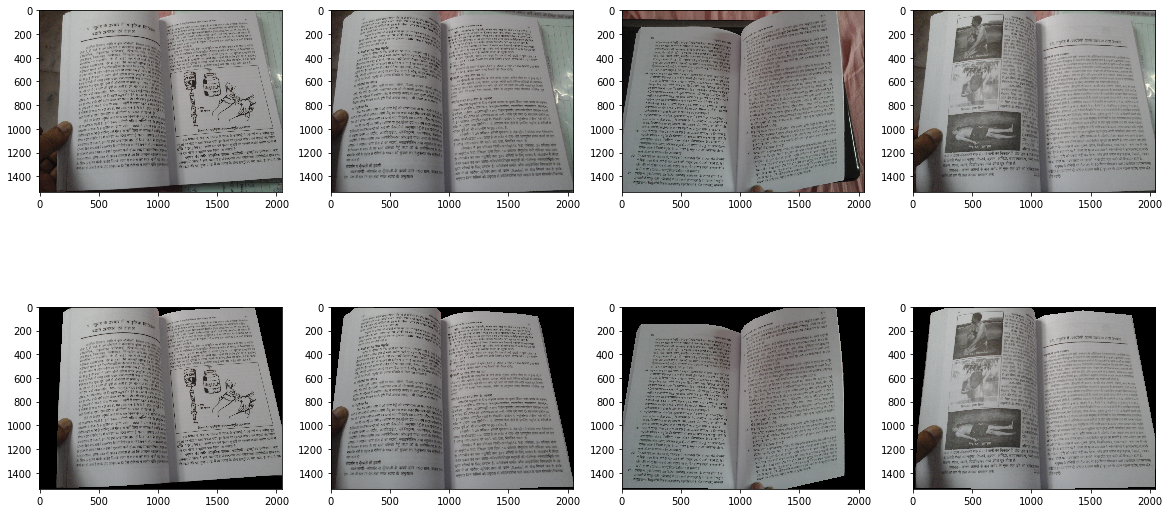

In [11]:
_,ax=plt.subplots(nrows=2,ncols=4,figsize=(20,10))
for idx, i in enumerate(np.random.choice(len(raw_data),size=4,replace=False)):
  img = get_img(raw_data[i],os.path.join(DATA_DIR,'data'))
  mask =get_mask(raw_data[i])
  ax[0,idx].imshow(img)
  ax[1,idx].imshow(img*(mask).reshape((mask.shape[0],mask.shape[1],1)))

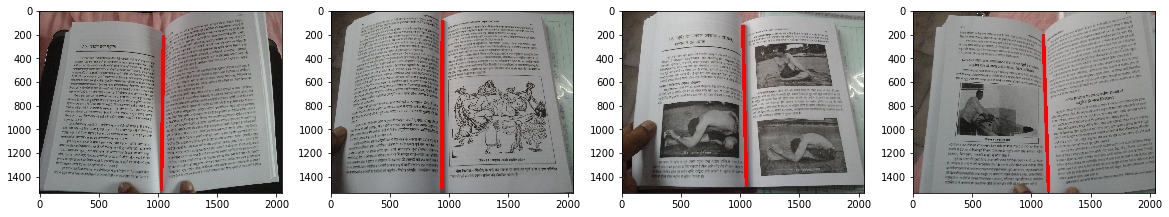

In [12]:
_,ax=plt.subplots(nrows=1,ncols=4,figsize=(20,5))
for idx, i in enumerate(np.random.choice(len(raw_data),size=4,replace=False)):
  img = get_img(raw_data[i],os.path.join(DATA_DIR,'data'))
  mask =get_midline_mask(raw_data[i])
  img[mask>0,0] = 254
  img[mask>0,1] = 0
  img[mask>0,2] = 0
  ax[idx].imshow(img)
  

## Data Preparation for model training

In [13]:
import keras
# from data_utils import get_img, get_mask, load_json
import numpy as np
import albumentations as A

IMG_SIZE = (320, 320)
MIN_SCALE = 0.5

def get_validation_augmentation():
    return A.Compose([A.Resize(IMG_SIZE[0], IMG_SIZE[1])], p=1)


class DataLoader:
    def __init__(
            self,
            json_path: str,
            img_directory: str,
            augmentation=None,
            batch_size: int = 8,
            load_midline_data=False,
    ):
        """
        Args:
            json_path: path of the json file generated by Labelbox website.
            img_directory: directory where images are present
        """
        self.load_midline_data = load_midline_data
        self.json = load_json(json_path)
        self.imgs = np.stack([get_img(row, img_directory) for row in self.json], axis=0)
        if self.load_midline_data:
            self.masks = np.stack([get_midline_mask(row) for row in self.json], axis=0)
        else:
            self.masks = np.stack([get_mask(row) for row in self.json], axis=0)
        self.masks = self.masks.reshape((self.masks.shape[0], self.masks.shape[1], self.masks.shape[2], 1))
        self.aug = augmentation

    def __getitem__(self, i):
        if self.aug is not None:
            sample = self.aug(image=self.imgs[i], mask=self.masks[i])
            return (sample['image'], sample['mask'])

        return (self.imgs[i].copy(), self.masks[i].copy())

    def __len__(self):
        return len(self.imgs)


Using TensorFlow backend.


In [0]:
# JSON_PATH = '/content/gdrive/My Drive/Colab_data/PagePixelSegmentation/book_segmentation.json'
IMG_DIR = '/content/gdrive/My Drive/Colab_data/PagePixelSegmentation/data'

aug = get_validation_augmentation()
json_path = os.path.join(DATA_DIR,'export-2019-12-20T02_15_02.061Z.json')
datagen = DataLoader(json_path,IMG_DIR,augmentation=aug,batch_size=BATCH_SIZE,load_midline_data=False)

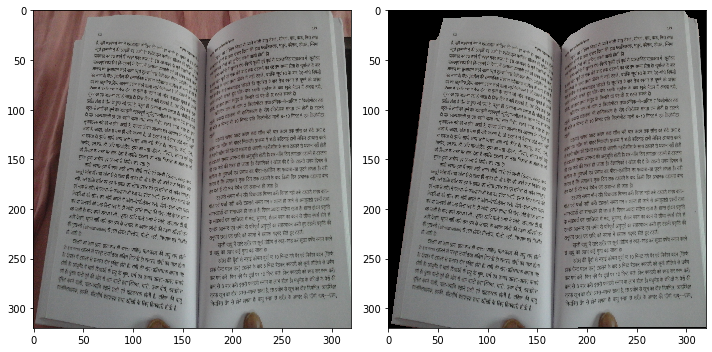

In [15]:
sample = datagen[10]
img,msk = sample[0],sample[1]
plot(img,msk[:,:,0])

## Using trained models for segmentation

In [16]:
import segmentation_models as sm

BACKBONE = 'efficientnetb3'
LR = 0.0001
EPOCHS = 30
def get_model():
  preprocess_input = sm.get_preprocessing(BACKBONE)
  activation = 'sigmoid'
  model = sm.Unet(BACKBONE, classes=1, activation=activation)
  optim = keras.optimizers.Adam(LR)
  total_loss = sm.losses.binary_focal_dice_loss
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  # compile keras model with defined optimozer, loss and metrics
  model.compile(optim, total_loss, metrics)
  return model

Segmentation Models: using `keras` framework.


In [17]:
midline_model = get_model()
boundary_model= get_model()
midline_model.load_weights(os.path.join(DATA_DIR,'mid_boundary_pixel.h5'))
boundary_model.load_weights(os.path.join(DATA_DIR,'bookboundary_model.h5'))












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
44113920/44107200 [==============================] - 2s 0us/step






In [0]:
X = []
X_map = []
for elem in datagen:
  X.append(elem[0])
  X_map.append(elem[1])
X = np.stack(X)
X_map = np.stack(X_map)

In [0]:
# midline_pred = midline_model.predict(X)
boundary_pred = boundary_model.predict(X)
boundary_pred = boundary_pred[:,np.newaxis,:,:,0]

In [21]:
H,W = boundary_pred.shape[2:]
boundary_pred.shape

(123, 1, 320, 320)

In [22]:
probs_normalized = boundary_pred
# probs_normalized = (boundary_pred-boundary_pred.min()) / (boundary_pred.max()-boundary_pred.min())
# probs_normalized = 0.5 + 0.2 * (probs_normalized-0.5)
bck = 1 - probs_normalized
probab = np.concatenate([bck, probs_normalized],axis=1)
# probab = np.swapaxes(probab, 0, -1)
probab.shape

(123, 2, 320, 320)

In [23]:
probab[:,1,:,:].max()

0.99496317

In [0]:
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral


In [25]:
from tqdm import tqdm_notebook
# There params have been obtained by looking at the performance of just one image. So no overfitting here.
compat = 2
sxy  = 10
srgb = 1
raw_KL = []
CRF_KL = []
for i in tqdm_notebook(range(X.shape[0])):
      neg_log_probab = unary_from_softmax(probab[i])

      d = dcrf.DenseCRF2D(X.shape[1], X.shape[2], 2)
      d.setUnaryEnergy(neg_log_probab)
      d.addPairwiseBilateral(sxy=sxy, srgb=srgb, rgbim=X[i], compat=compat)

      Q_unary = d.inference(20)
      mask = np.argmax(Q_unary, axis=0).reshape((H,W))

      from scipy.stats import entropy
      pred_dist = np.array(Q_unary).reshape((2,H,W))
      act_dist = np.concatenate([1 - X_map[i][np.newaxis,:,:,0],X_map[i][np.newaxis,:,:,0]],axis=0)
      
      raw_pred_dist = np.concatenate([1 - boundary_pred[i],boundary_pred[i]],axis=0)

      CRF_KL.append(np.mean(entropy(act_dist,pred_dist)))
      raw_KL.append(np.mean(entropy(act_dist,raw_pred_dist)))


## KL divergence improves when one uses CRF over CNN prediction

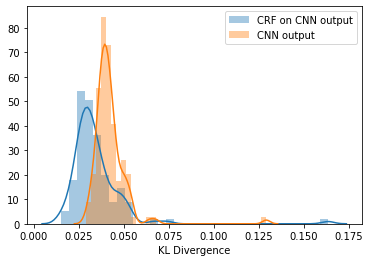

In [26]:
import seaborn as sns
_,ax= plt.subplots()
sns.distplot(CRF_KL,ax=ax, label = 'CRF on CNN output')
sns.distplot(raw_KL,ax=ax, label = 'CNN output')

ax.set(xlabel='KL Divergence')

plt.legend() 
# plt.show()

## Some of the better examples.

Text(0.5, 1.0, 'CNN based segmentation')

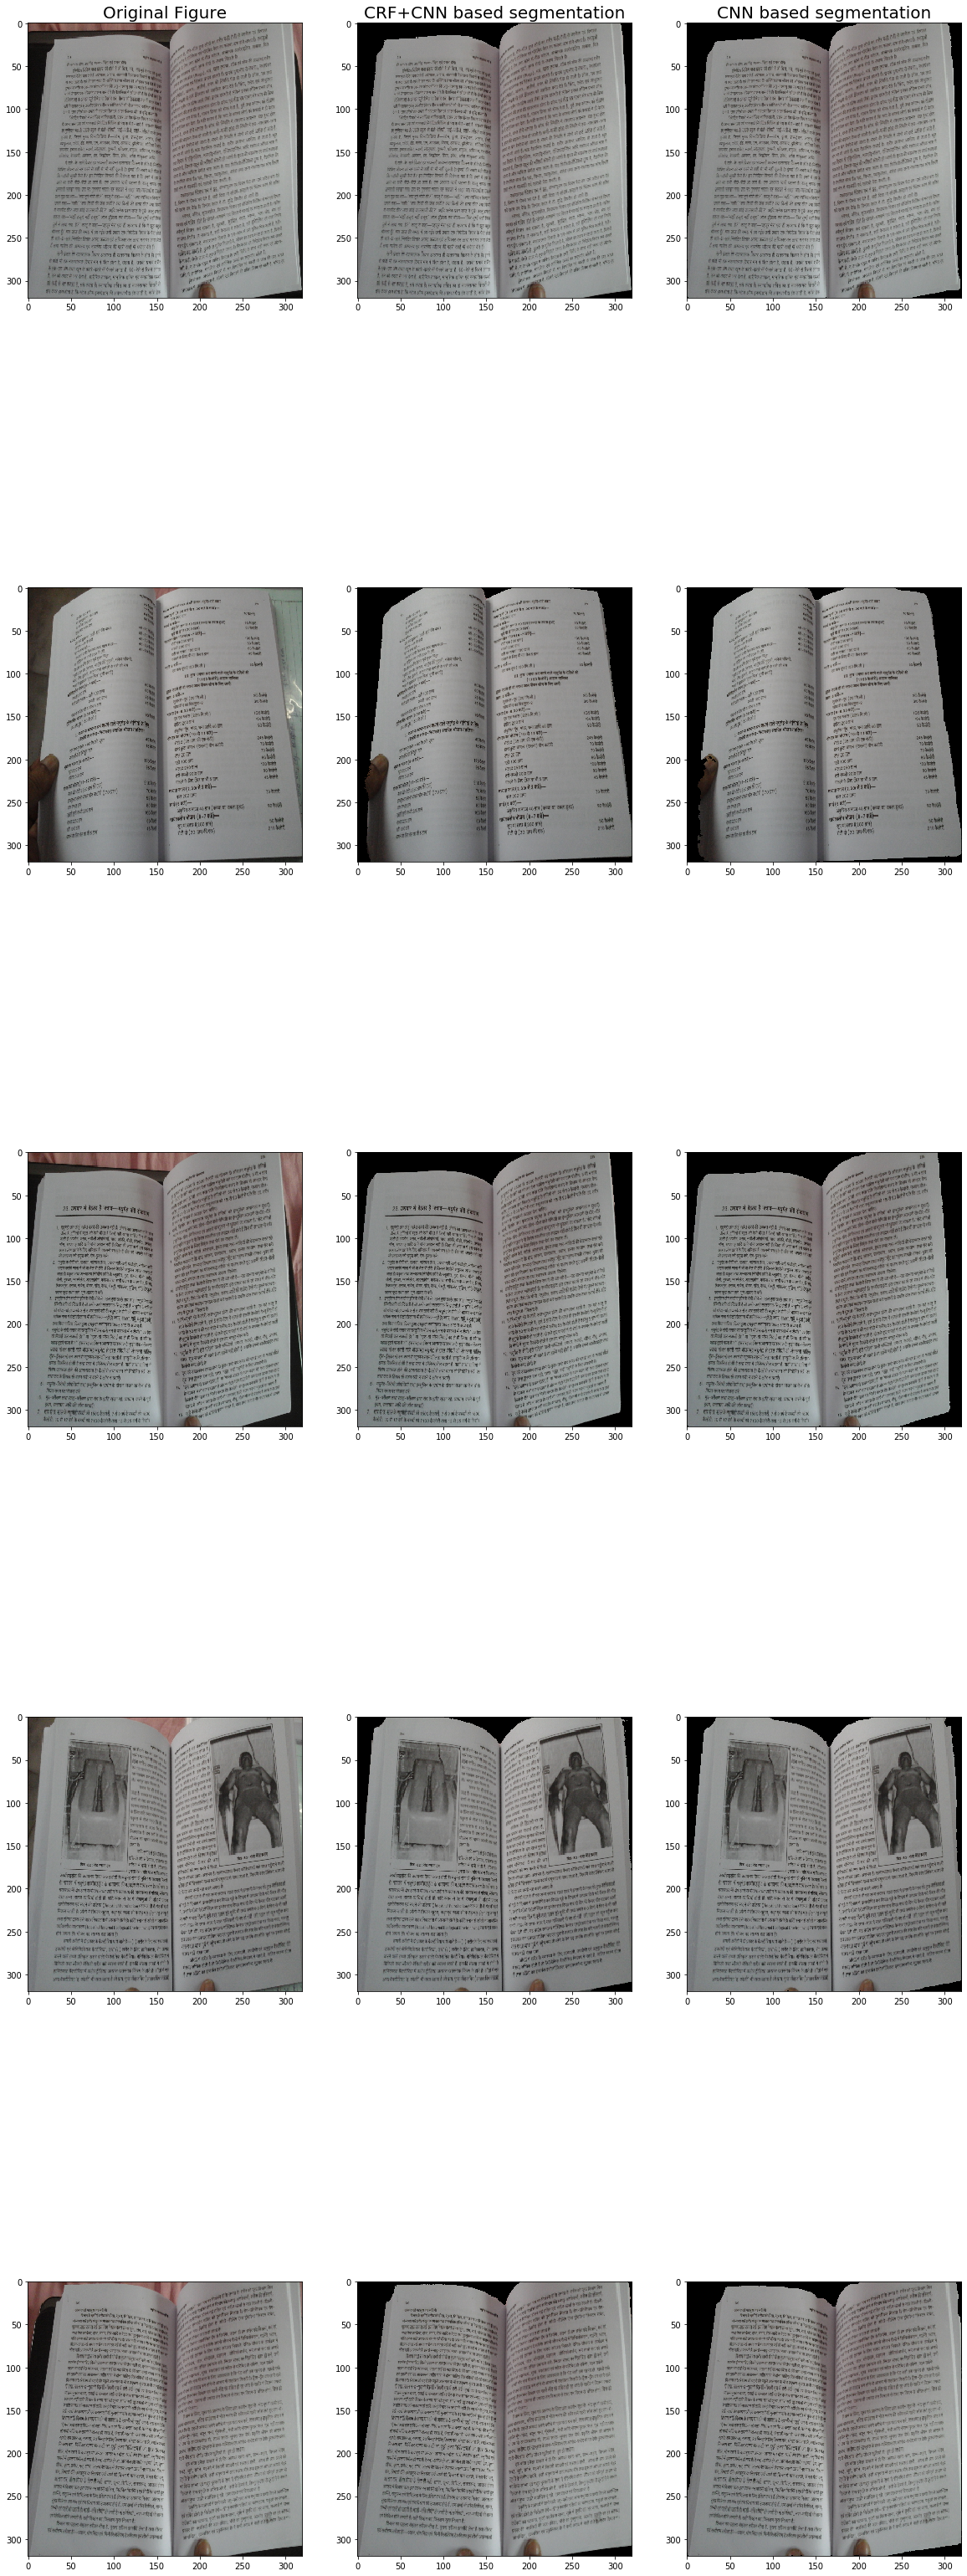

In [55]:
_, ax = plt.subplots(figsize=(20,60),ncols=3,nrows=5)
for idx, i in enumerate([118,96,88,75,106]):

  neg_log_probab = unary_from_softmax(probab[i])

  d = dcrf.DenseCRF2D(X.shape[1], X.shape[2], 2)
  d.setUnaryEnergy(neg_log_probab)
  d.addPairwiseBilateral(sxy=sxy, srgb=srgb, rgbim=X[i], compat=compat)

  Q_unary = d.inference(20)
  mask = np.argmax(Q_unary, axis=0).reshape((H,W))


  from scipy.stats import entropy
  pred_dist = np.array(Q_unary).reshape((2,H,W))
  act_dist = np.concatenate([1 - X_map[i][np.newaxis,:,:,0],X_map[i][np.newaxis,:,:,0]],axis=0)
  raw_pred_dist = np.concatenate([1 - boundary_pred[i],boundary_pred[i]],axis=0)

  # print('KL divergence: CRF:', np.mean(entropy(act_dist,pred_dist)), ' Basic:', np.mean(entropy(act_dist, raw_pred_dist)))

  raw_mask = boundary_pred[i][0].copy()
  raw_mask[raw_mask < 0.9] = 0
  raw_mask[raw_mask >0] = 1
  ax[idx, 0].imshow(X[i])
  ax[idx, 1].imshow(mask.astype('float32')[:,:,np.newaxis] *X[i]/255 )
  ax[idx, 2].imshow(raw_mask[:,:,np.newaxis] *X[i]/255)

ax[0,0].set_title('Original Figure', fontsize=20)
ax[0,1].set_title('CRF+CNN based segmentation', fontsize=20)
_ = ax[0,2].set_title('CNN based segmentation', fontsize=20)